# Setup

In [ ]:
%pip install mnist gensim
%pip install tensorflow

In [1]:
import os
import math
import time
import psutil
import random
import pandas as pd
import numpy as np
import networkx as nx

import mnist
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.utils as utils
from torch_geometric.utils import to_networkx

import tensorflow as tf
from tensorflow.keras.datasets import mnist

from sklearn.linear_model import Ridge, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, confusion_matrix
from sklearn.preprocessing import StandardScaler
from gensim.models import Word2Vec


In [2]:
def set_seed(random_seed):
    random.seed(random_seed)
    np.random.seed(random_seed)
    torch.manual_seed(random_seed)

set_seed(99)

# Data Preprocessing

In [3]:
dataset_path = '/Users/gitaayusalsabila/Documents/0thesis/code/sandbox/dataset/'
# dataset_path = '/notebooks/dataset/'

### Slim Dataset

In [4]:
def data_cleansing(dataset):
    # Replace negative values with 0
    dataset[dataset < 0] = 0
    
    # Replace NaN values with 0
    dataset = np.nan_to_num(dataset, nan=0)
    
    return dataset

def check_and_drop_invalid_graphs(graph_dataset):
    """
    Check that all graphs in the dataset have more than 0 edges and drop graphs with 0 edges in any timepoint or dimension.
    
    Parameters:
    graph_dataset (np.ndarray): The input graph dataset with shape [g, t, n, n, d] or [g, t, n, n]
    
    Returns:
    np.ndarray: The cleaned dataset with invalid graphs removed
    """
    
    # Check the shape of the dataset to determine if it has multiple dimensions
    if len(graph_dataset.shape) == 5:
        num_graphs, num_timepoints, num_nodes, _, num_dimensions = graph_dataset.shape
    else:
        num_graphs, num_timepoints, num_nodes, _ = graph_dataset.shape
        num_dimensions = 1
    
    valid_graphs = []

    for i in range(num_graphs):
        is_valid = True
        for t in range(num_timepoints):
            for d in range(num_dimensions):
                if num_dimensions > 1:
                    adj_matrix = graph_dataset[i, t, :, :, d]
                else:
                    adj_matrix = graph_dataset[i, t, :, :]
                
                num_edges = np.sum(adj_matrix > 0)
                if num_edges == 0:
                    is_valid = False
                    break
            if not is_valid:
                break
        
        if is_valid:
            valid_graphs.append(i)
    
    if num_dimensions > 1:
        cleaned_dataset = graph_dataset[valid_graphs, :, :, :, :]
    else:
        cleaned_dataset = graph_dataset[valid_graphs, :, :, :]
    
    return cleaned_dataset

# Load Graph Data
slim160 = np.load(dataset_path + 'slim160_adj.npy')
slim268 = np.load(dataset_path + 'slim268_adj.npy')

slim160_cleaned = data_cleansing(slim160)
slim160_cleaned = check_and_drop_invalid_graphs(slim160_cleaned)
print('slim160 shape:',slim160_cleaned.shape)

slim268_cleaned = data_cleansing(slim268)
slim268_cleaned = check_and_drop_invalid_graphs(slim268_cleaned)
print('slim268 shape:',slim268_cleaned.shape)

maturation_data = np.load(dataset_path + 'maturation_adj.npy')
print('mature shape:',maturation_data.shape)

slim160 shape: (109, 3, 160, 160)
slim268 shape: (109, 3, 268, 268)
mature shape: (77, 9, 300, 300)


In [5]:
def extract_subgraphs(adjacency_matrix):
    """
    Extract subgraphs for each node in the graph.
    """
    n_nodes = adjacency_matrix.shape[0]
    subgraphs = []
    
    for node in range(n_nodes):
        subgraph_nodes = [node] + list(np.nonzero(adjacency_matrix[node])[0])
        subgraph = adjacency_matrix[np.ix_(subgraph_nodes, subgraph_nodes)]
        subgraphs.append(subgraph)
    
    return subgraphs

def extract_all_subgraphs(dataset):
    """
    Extract subgraphs for each node in each graph in the dataset.
    """
    all_subgraphs = []
    
    for subject in range(dataset.shape[0]):
        for timepoint in range(dataset.shape[1]):
            adjacency_matrix = dataset[subject, timepoint]
            subgraphs = extract_subgraphs(adjacency_matrix)
            all_subgraphs.append((subject, timepoint, subgraphs))
    
    return all_subgraphs

# Example usage
slim160_subgraphs = extract_all_subgraphs(slim160_cleaned)

## Maturation Dataset

In [5]:
import numpy as np

# Example arrays
A = np.random.rand(693)  # Shape (693,)
B = np.random.rand(693, 300, 300)  # Shape (693, 300, 300)

# Reshape A to (693, 1, 1, 1)
A_reshaped = A.reshape(693, 1, 1, 1)

# Expand A to match B's shape in the new dimension
A_expanded = np.tile(A_reshaped, (1, 1, 300, 300))

# Verify the shape of A_expanded
print("Shape of A_expanded:", A_expanded.shape)  # Should be (693, 1, 300, 300)

# Since we want a combined array of shape (693, 1, 300, 300), we need to ensure it contains the information from B as well.
# To do this, we should create a combined array that directly integrates the data from B:

# Initialize the combined array with the shape (693, 1, 300, 300)
combined_array = np.zeros((693, 1, 300, 300))

# Assign the values of B to the combined array
combined_array[:, 0, :, :] = B

# Verify the shape of combined_array
print("Shape of combined array:", combined_array.shape)  # Should be (693, 1, 300, 300)


Shape of A_expanded: (693, 1, 300, 300)
Shape of combined array: (693, 1, 300, 300)


In [53]:
def transform_and_filter_data(connectome_array):
    s, t, n, _ = connectome_array.shape
    
    # Step 1: Create time labels
    time_labels_list = []
    for i in range(s):
        for j in range(t):
            time_labels_list.append(j+1)
    
    time_labels_ori = np.array(time_labels_list)
    time_labels = time_labels_ori.reshape(s*t, 1)
    time_labels_expanded = np.tile(A_reshaped, (1, 1, n, n))

    flattened_connectomic_array = connectome_array.reshape(-1, n, n)

    transformed_data = np.zeros((693, 1, 300, 300))
    transformed_data[:, 0, :, :] = flattened_connectomic_array
    transformed_data[:, :, 0, 0] = time_labels
    print("Shape of flattened connectomic array:", transformed_data.shape)
    
    # Step 2: Filter out graphs with NaN values
    mask = ~np.isnan(transformed_data).any(axis=(1, 2, 3))
    filtered_data = transformed_data[mask]
    
    return filtered_data,time_labels_ori

In [54]:
transformed_and_filtered_data, time_labels = transform_and_filter_data(maturation_data)
print("Shape of transformed and filtered data:", transformed_and_filtered_data.shape)

# checked transformed data
second_dim_values = transformed_and_filtered_data[:, 0, 0, 0]
unique_values = np.unique(second_dim_values)
print(f"Unique values in the second dimension: {unique_values}")

Shape of flattened connectomic array: (693, 1, 300, 300)
Shape of transformed and filtered data: (262, 1, 300, 300)
Unique values in the second dimension: [1. 2. 3. 4. 5. 6. 7. 8. 9.]


# Cognitive Property Calculation

In [6]:
# Function to initialize the ESN with given adjacency matrix
def initialize_esn(adjacency_matrix, input_size, reservoir_size, output_size):
    set_seed(99)
    Win = np.random.rand(reservoir_size, input_size) - 0.5
    Wout = np.random.rand(output_size, reservoir_size) - 0.5
    Wres = adjacency_matrix
    return Win, Wres, Wout

# Function to calculate MAE for ESN
def calculate_mae(Win, Wres, Wout, input_data, target_data):
    # Initialize states
    n_reservoir = Wres.shape[0]
    n_samples = input_data.shape[0]
    states = np.zeros((n_samples, n_reservoir))
    
    for t in range(1, n_samples):
        states[t] = np.tanh(np.dot(Wres, states[t-1]) + np.dot(Win, input_data[t]))
    
    outputs = np.dot(states, Wout.T)
    mae = mean_absolute_error(target_data, outputs)
    return mae

In [7]:
# Generate the Mackey-Glass sequence
def generate_mackey_glass_sequence(tau=17, n_samples=1000, delta_t=1, beta=0.2, gamma=0.1, n=10):
    x = np.zeros(n_samples)
    x[0] = 1.2  # Initial condition

    for t in range(1, n_samples):
        if t - tau >= 0:
            x[t] = x[t-1] + (beta * x[t-tau] / (1 + x[t-tau]**n) - gamma * x[t-1]) * delta_t
        else:
            x[t] = x[t-1]  # Use previous value if index is out of bounds

    return x

# Generate the number sequence data (Mackey-Glass sequence)
def generate_number_sequence_data():
    mackey_glass_sequence = generate_mackey_glass_sequence()
    mackey_target = np.roll(mackey_glass_sequence, -1)  # Target is the next value in the sequence
    return mackey_glass_sequence.reshape(-1, 1), mackey_target.reshape(-1, 1)

# Load and preprocess MNIST data
def load_mnist_data():
    (train_images, train_labels), _ = mnist.load_data()
    return train_images, train_labels

# Generate simple word2vec model and data
def generate_word2vec_data():
    sentences = [["cat", "sat", "on", "the", "mat"],
                 ["dog", "barked", "at", "the", "moon"],
                 ["man", "drank", "coffee"]]
    model = Word2Vec(sentences, vector_size=10, window=5, min_count=1, workers=4)
    word_input = np.array([model.wv[word] for word in ["cat", "sat", "on", "the", "mat"]])
    word_target = np.roll(word_input, -1, axis=0)
    return word_input, word_target

# Generate tasks data
def generate_tasks_data():
    # Number sequence (Mackey-Glass sequence)
    number_sequence, number_target = generate_number_sequence_data()
    
    # MNIST sequence
    mnist_train_images, mnist_train_labels = load_mnist_data()
    mnist_input = mnist_train_images.reshape(-1, 28*28)[:100]
    mnist_target = mnist_train_labels[:100].reshape(-1, 1)
    
    # Word2Vec sequence
    word_input, word_target = generate_word2vec_data()
    
    return (number_sequence, number_target), (mnist_input, mnist_target), (word_input, word_target)

# Generate tasks data
(number_sequence, number_target), (mnist_input, mnist_target), (word_input, word_target) = generate_tasks_data()

#### SLIM Dataset (Subgraphs)

In [9]:
import time
import pandas as pd
from joblib import Parallel, delayed

def process_subgraph(subgraph_index, subgraph, generate_tasks_data, initialize_esn, calculate_mae):
    subgraph_size = subgraph.shape[0]
    (number_sequence, number_target), (mnist_input, mnist_target), (word_input, word_target) = generate_tasks_data()
    
    # Calculate MAE for number sequence
    Win, Wres, Wout = initialize_esn(subgraph, input_size=1, reservoir_size=subgraph_size, output_size=1)
    number_mae = calculate_mae(Win, Wres, Wout, number_sequence, number_target)

    # Calculate MAE for MNIST sequence
    Win, Wres, Wout = initialize_esn(subgraph, input_size=28*28, reservoir_size=subgraph_size, output_size=1)
    mnist_mae = calculate_mae(Win, Wres, Wout, mnist_input, mnist_target)

    # Calculate MAE for Word2Vec sequence
    Win, Wres, Wout = initialize_esn(subgraph, input_size=10, reservoir_size=subgraph_size, output_size=10)
    word_mae = calculate_mae(Win, Wres, Wout, word_input, word_target)
    
    return subgraph_index, number_mae, mnist_mae, word_mae

def calculate_subgraphs_mae(all_subgraphs):
    mae_results = []
    subject_times = []

    for subject, timepoint, subgraphs in all_subgraphs:
        print(f'Calculating subgraphs MAE of subject {subject+1} at timepoint {timepoint+1} ')
        start_time = time.time()

        subgraph_data = [(i, subgraph, generate_tasks_data, initialize_esn, calculate_mae) for i, subgraph in enumerate(subgraphs)]
        
        results = Parallel(n_jobs=-1)(delayed(process_subgraph)(i, subgraph, generate_tasks_data, initialize_esn, calculate_mae) for i, subgraph in enumerate(subgraphs))

        for subgraph_index, number_mae, mnist_mae, word_mae in results:
            mae_results.append((subject, timepoint, subgraph_index, number_mae, mnist_mae, word_mae))
        
        subject_time = time.time() - start_time
        subject_times.append(subject_time)
        print(f"Time taken for subject {subject}: {subject_time:.2f} seconds")
    
    average_time = sum(subject_times) / len(subject_times)
    print(f"Average time taken across subjects: {average_time:.2f} seconds")

    return mae_results

# Example usage
subgraphs_mae_results = calculate_subgraphs_mae(slim160_subgraphs)
subgraphs_mae_df = pd.DataFrame(subgraphs_mae_results, columns=['Subject', 'Timepoint', 'Subgraph_Index', 'Number_MAE', 'MNIST_MAE', 'Word_MAE'])
subgraphs_mae_df.to_csv('mae_df_subgraphs.csv')

Calculating subgraphs MAE of subject 1 at timepoint 1 
Time taken for subject 0: 21.50 seconds
Calculating subgraphs MAE of subject 1 at timepoint 2 
Time taken for subject 0: 10.07 seconds
Calculating subgraphs MAE of subject 1 at timepoint 3 
Time taken for subject 0: 8.85 seconds
Calculating subgraphs MAE of subject 2 at timepoint 1 
Time taken for subject 1: 8.77 seconds
Calculating subgraphs MAE of subject 2 at timepoint 2 
Time taken for subject 1: 8.49 seconds
Calculating subgraphs MAE of subject 2 at timepoint 3 
Time taken for subject 1: 8.62 seconds
Calculating subgraphs MAE of subject 3 at timepoint 1 
Time taken for subject 2: 8.90 seconds
Calculating subgraphs MAE of subject 3 at timepoint 2 
Time taken for subject 2: 8.76 seconds
Calculating subgraphs MAE of subject 3 at timepoint 3 
Time taken for subject 2: 8.76 seconds
Calculating subgraphs MAE of subject 4 at timepoint 1 
Time taken for subject 3: 8.89 seconds
Calculating subgraphs MAE of subject 4 at timepoint 2 
Tim

In [11]:
subgraphs_mae_df

,Subject,Timepoint,Subgraph_Index,Number_MAE,MNIST_MAE,Word_MAE
0,0,0,0,3.589023,3.773428,1.053054
1,0,0,1,0.201178,5.524279,0.913534
2,0,0,2,0.480949,3.634977,0.649255
3,0,0,3,3.142698,5.981169,1.061533
4,0,0,4,1.277341,5.911319,1.280242
...,...,...,...,...,...,...
52315,108,2,155,1.976665,6.258613,0.904289
52316,108,2,156,0.824591,5.161903,1.006488
52317,108,2,157,1.975864,6.263205,0.832571
52318,108,2,158,0.823356,5.168556,0.922160


In [20]:
# Calculate the mean and standard deviation of MAE values for each subgraph index in each timepoint across all subjects
mae_stats = subgraphs_mae_df.groupby(['Timepoint', 'Subgraph_Index']).agg(
    Number_MAE_mean=('Number_MAE', 'mean'),
    Number_MAE_std=('Number_MAE', 'std'),
    MNIST_MAE_mean=('MNIST_MAE', 'mean'),
    MNIST_MAE_std=('MNIST_MAE', 'std'),
    Word_MAE_mean=('Word_MAE', 'mean'),
    Word_MAE_std=('Word_MAE', 'std')
).reset_index()

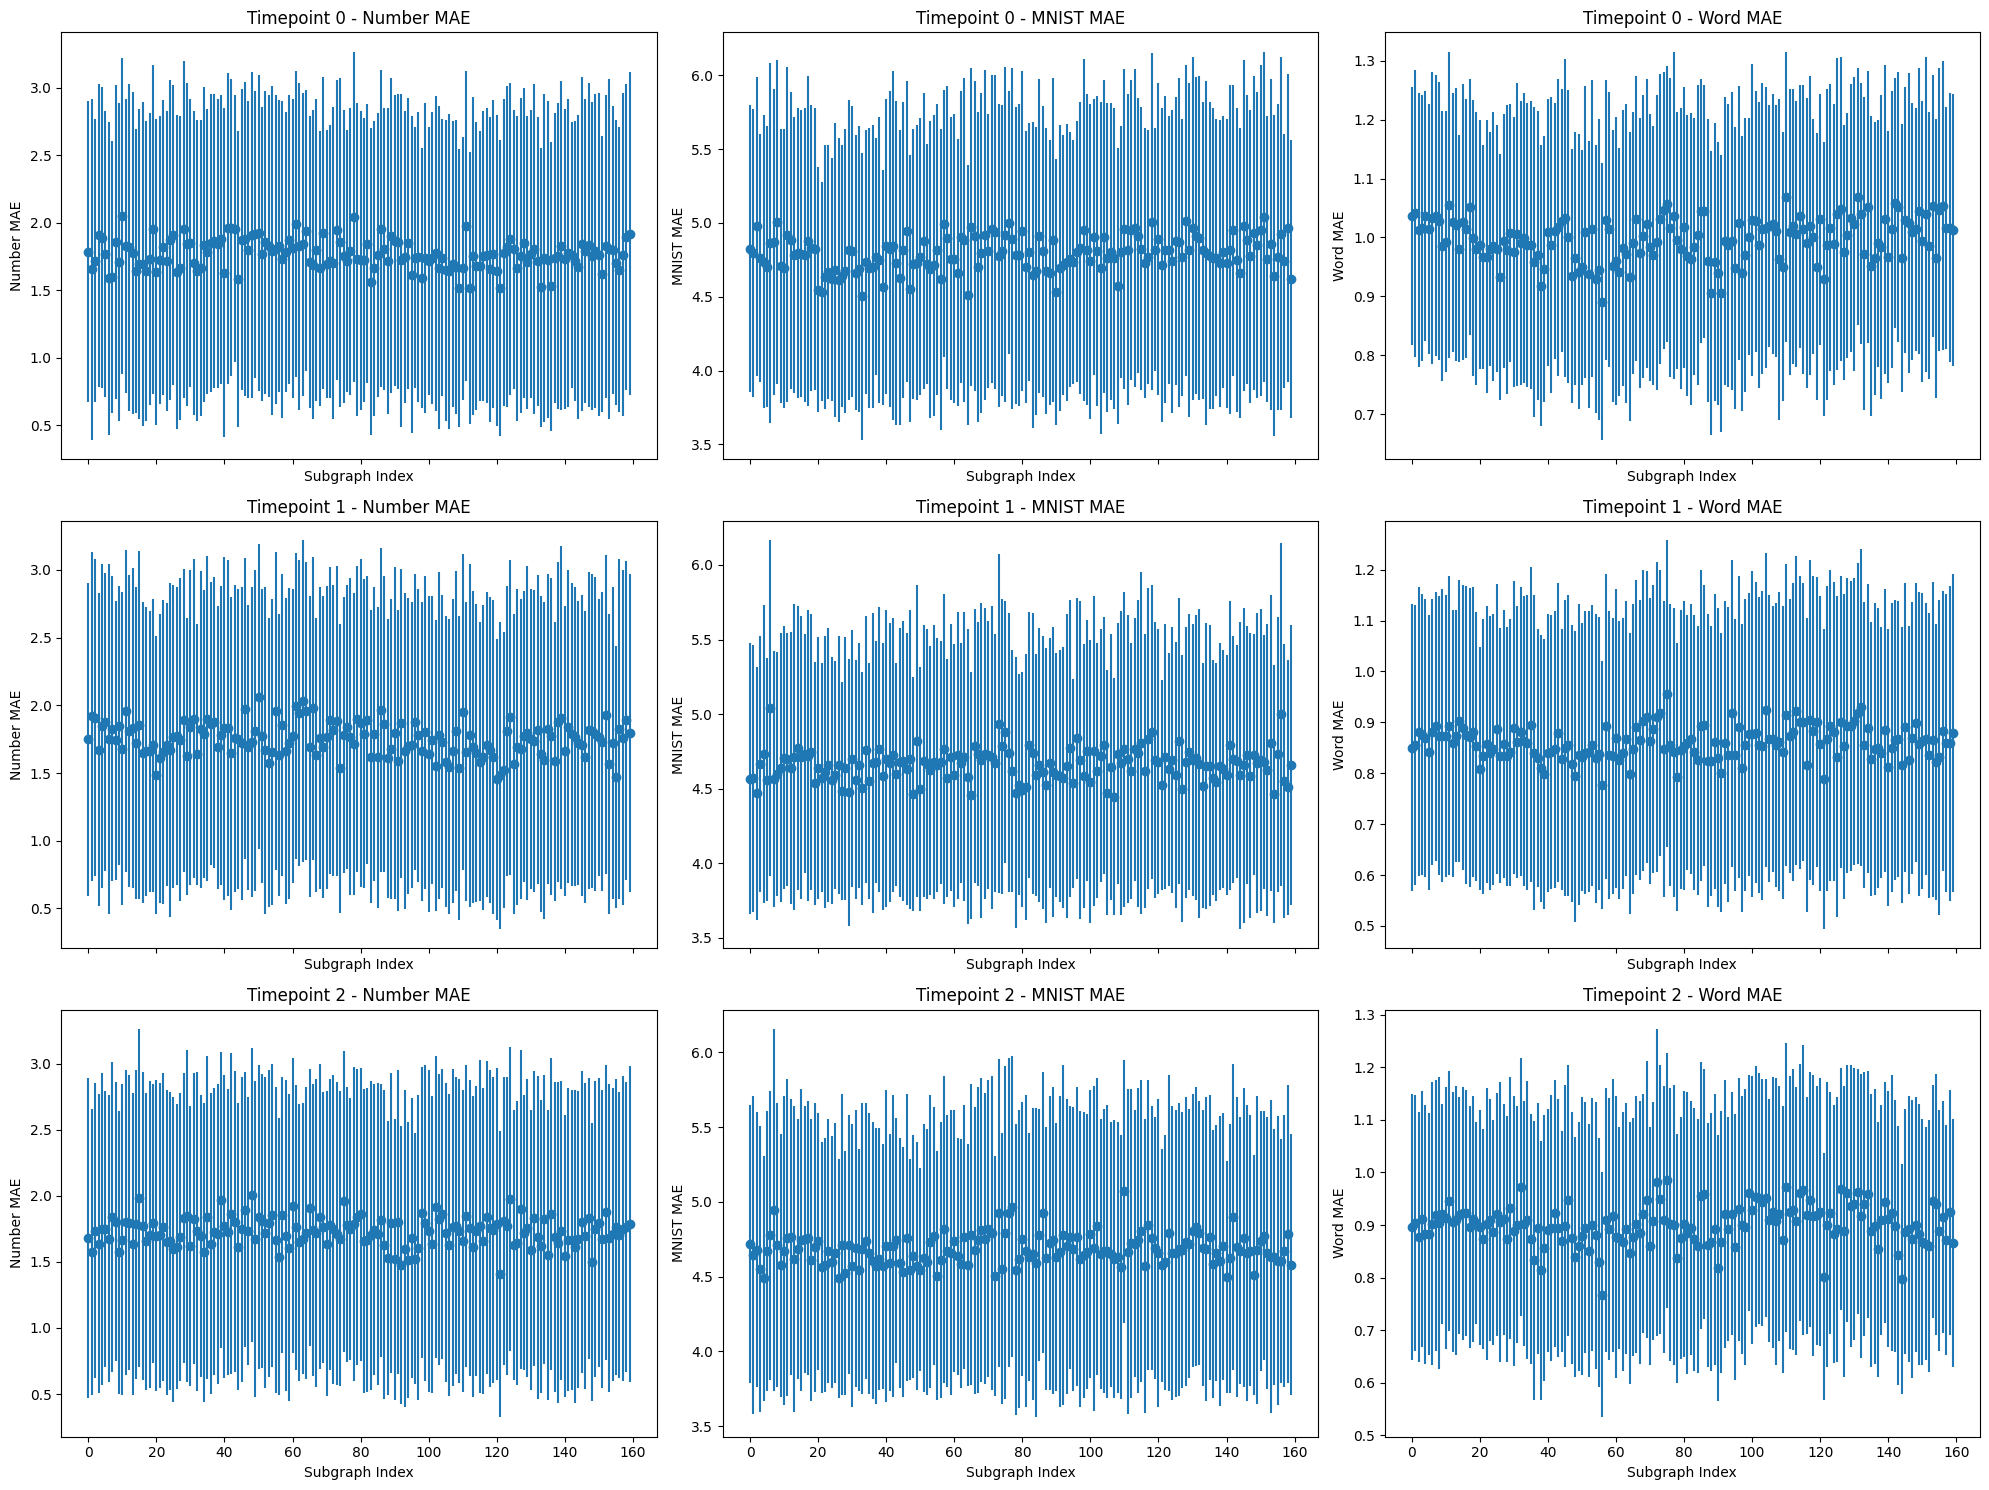

In [22]:
# Create a 3x3 subplot grid
fig, axes = plt.subplots(3, 3, figsize=(20, 15), sharex=True)

timepoints = subgraphs_mae_df['Timepoint'].unique()
tasks = ['Number', 'MNIST', 'Word']
task_columns = ['Number_MAE_mean', 'MNIST_MAE_mean', 'Word_MAE_mean']

for i, timepoint in enumerate(timepoints):
    for j, (task, task_column) in enumerate(zip(tasks, task_columns)):
        # Plot mean MAE values for the given timepoint and task
        axes[i, j].errorbar(
            mae_stats[mae_stats['Timepoint'] == timepoint]['Subgraph_Index'],
            mae_stats[mae_stats['Timepoint'] == timepoint][task_column],
            yerr=mae_stats[mae_stats['Timepoint'] == timepoint][task_column.replace('_mean', '_std')],
            fmt='o'
        )
        axes[i, j].set_title(f'Timepoint {timepoint} - {task} MAE')
        axes[i, j].set_xlabel('Subgraph Index')
        axes[i, j].set_ylabel(f'{task} MAE')

# Adjust layout and show the plots
plt.tight_layout()
plt.show()


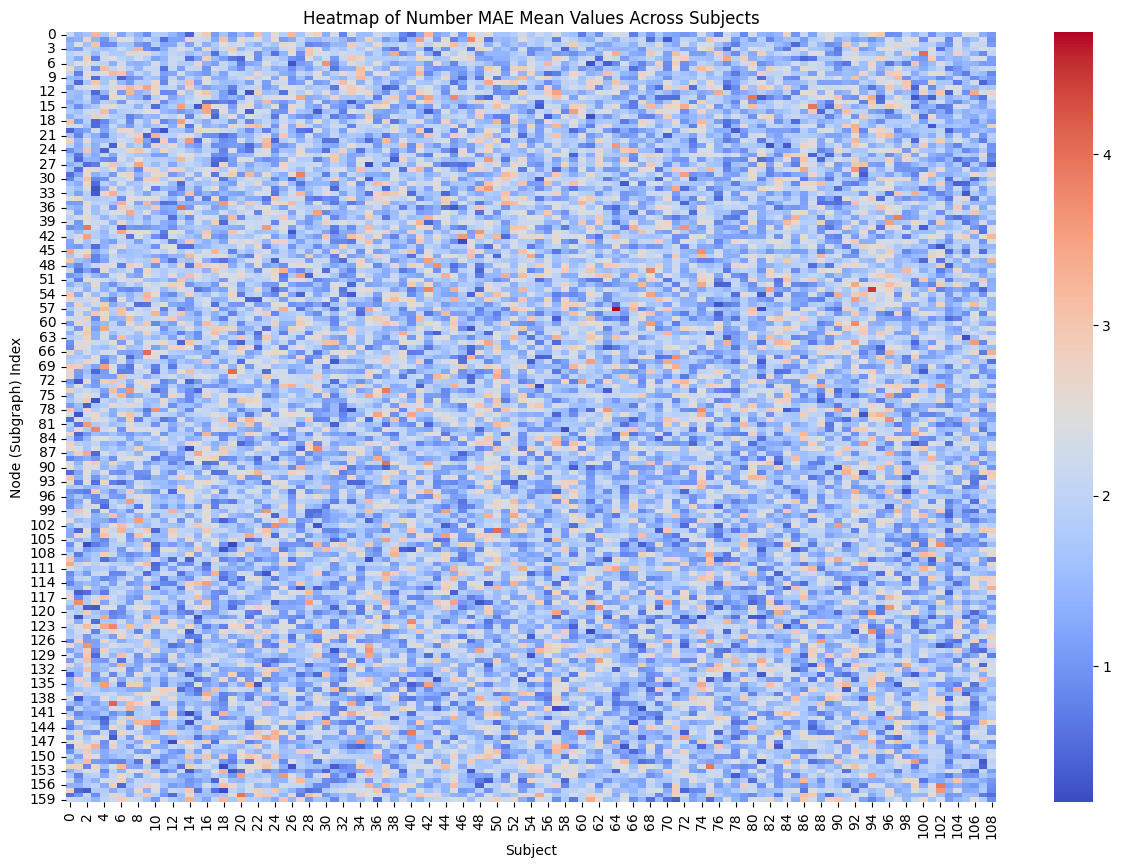

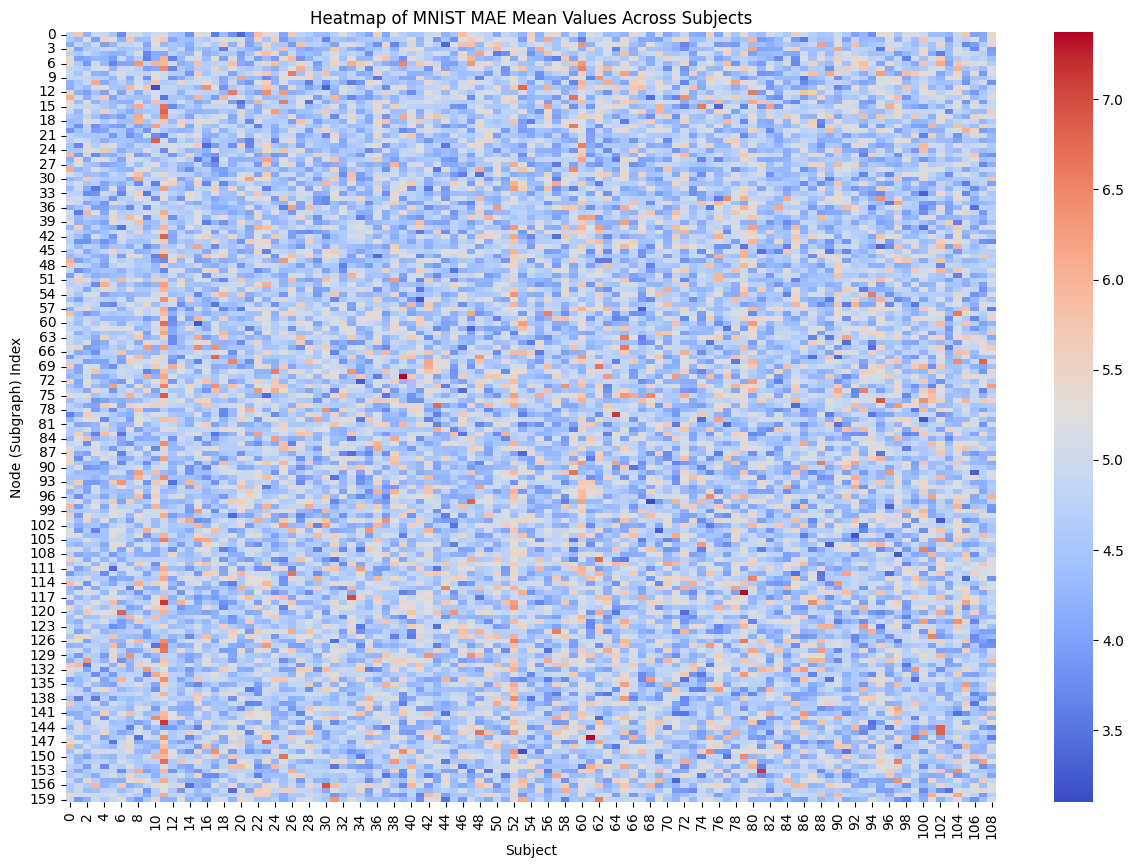

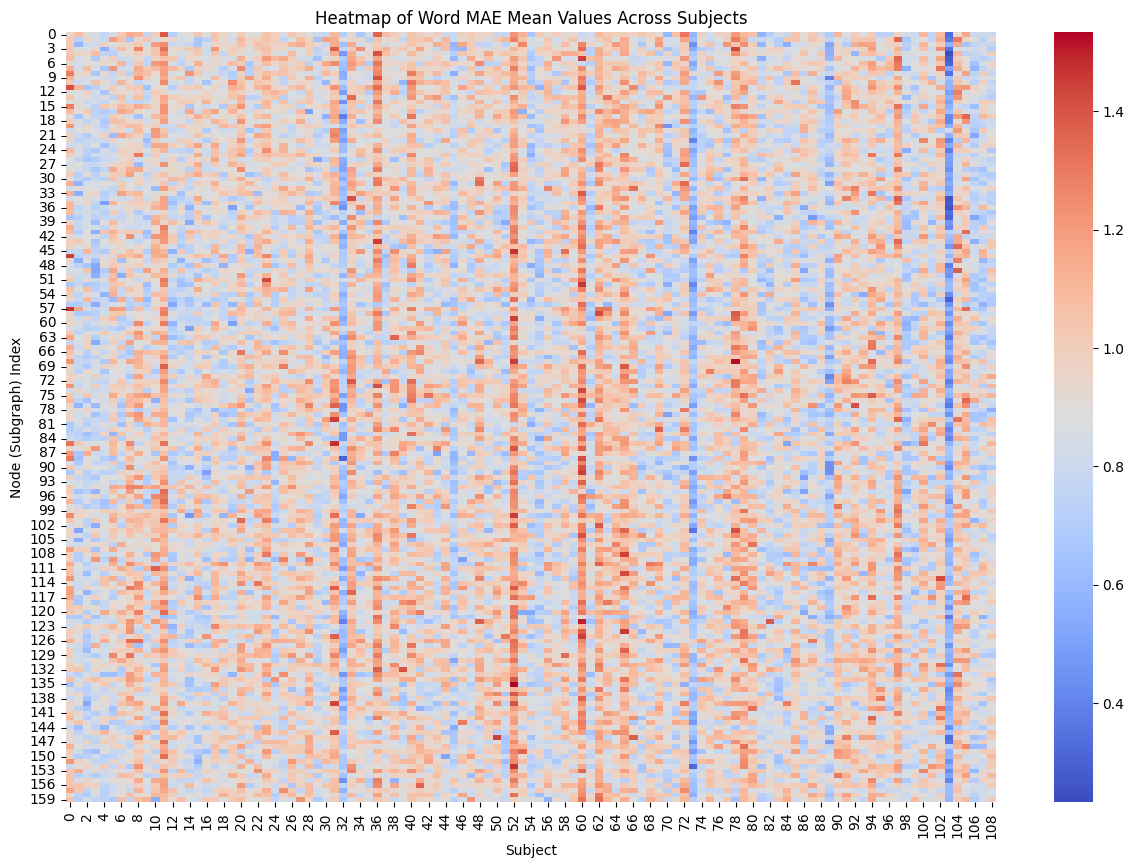

In [33]:
# Create heatmaps to represent the mean MAE values for each subgraph index across different tasks and timepoints
mean_mae_pivot = subgraphs_mae_df.pivot_table(index='Subgraph_Index', columns='Subject', values='Number_MAE', aggfunc='mean')
plt.figure(figsize=(15, 10))
sns.heatmap(mean_mae_pivot, annot=False, cmap='coolwarm')
plt.title('Heatmap of Number MAE Mean Values Across Subjects')
plt.xlabel('Subject')
plt.ylabel('Node (Subgraph) Index')
plt.show()

mean_mae_pivot = subgraphs_mae_df.pivot_table(index='Subgraph_Index', columns='Subject', values='MNIST_MAE', aggfunc='mean')
plt.figure(figsize=(15, 10))
sns.heatmap(mean_mae_pivot, annot=False, cmap='coolwarm')
plt.title('Heatmap of MNIST MAE Mean Values Across Subjects')
plt.xlabel('Subject')
plt.ylabel('Node (Subgraph) Index')
plt.show()

mean_mae_pivot = subgraphs_mae_df.pivot_table(index='Subgraph_Index', columns='Subject', values='Word_MAE', aggfunc='mean')
plt.figure(figsize=(15, 10))
sns.heatmap(mean_mae_pivot, annot=False, cmap='coolwarm')
plt.title('Heatmap of Word MAE Mean Values Across Subjects')
plt.xlabel('Subject')
plt.ylabel('Node (Subgraph) Index')
plt.show()


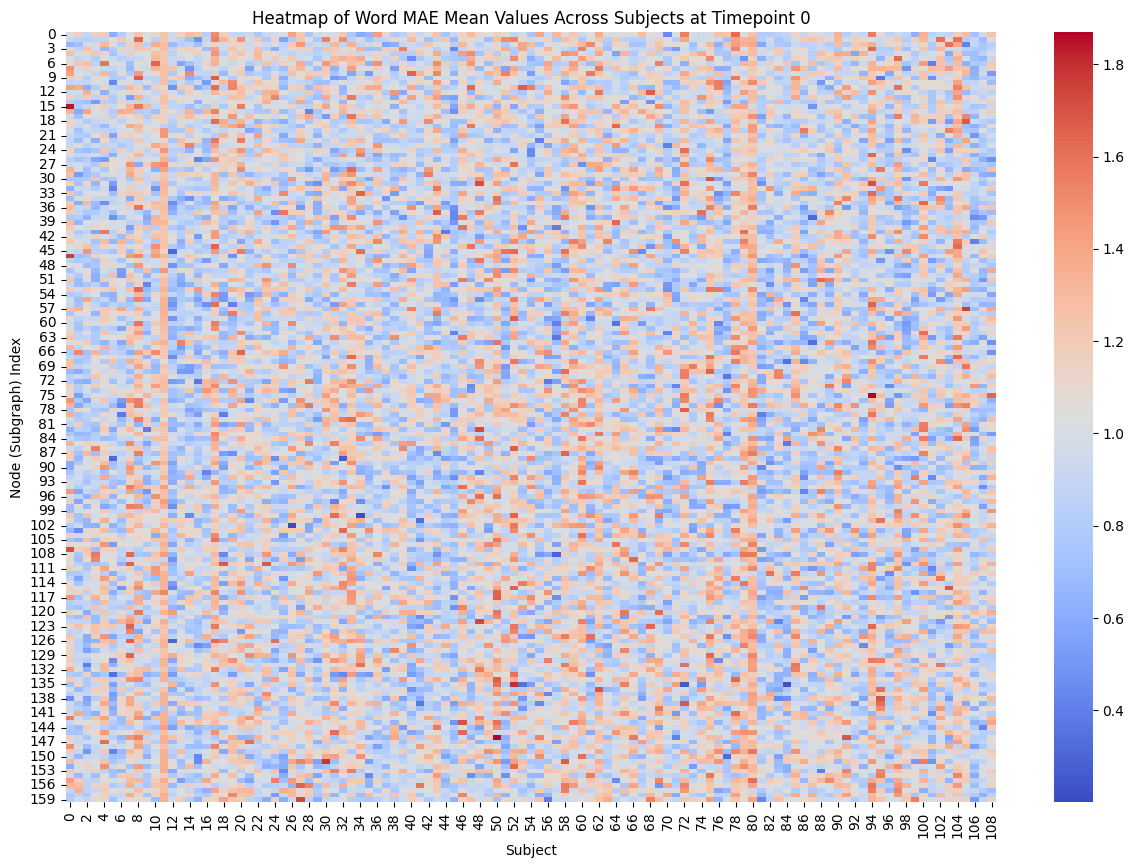

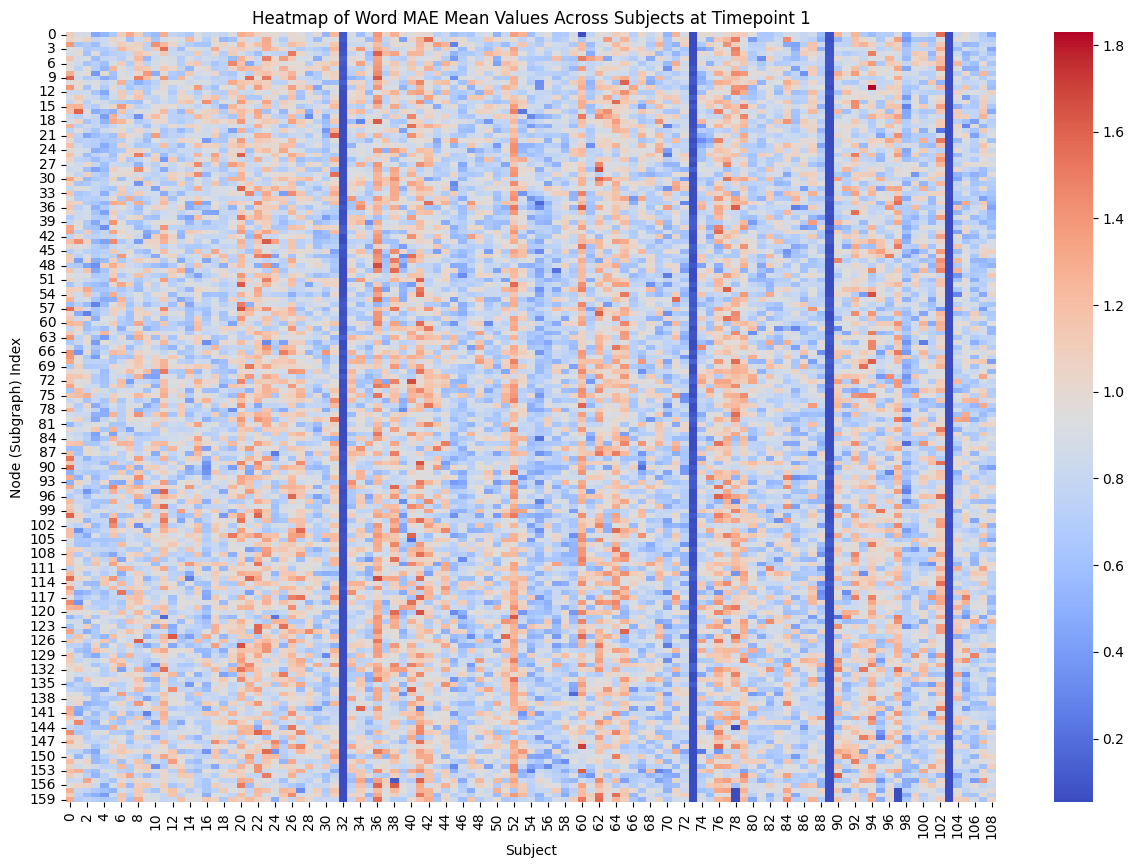

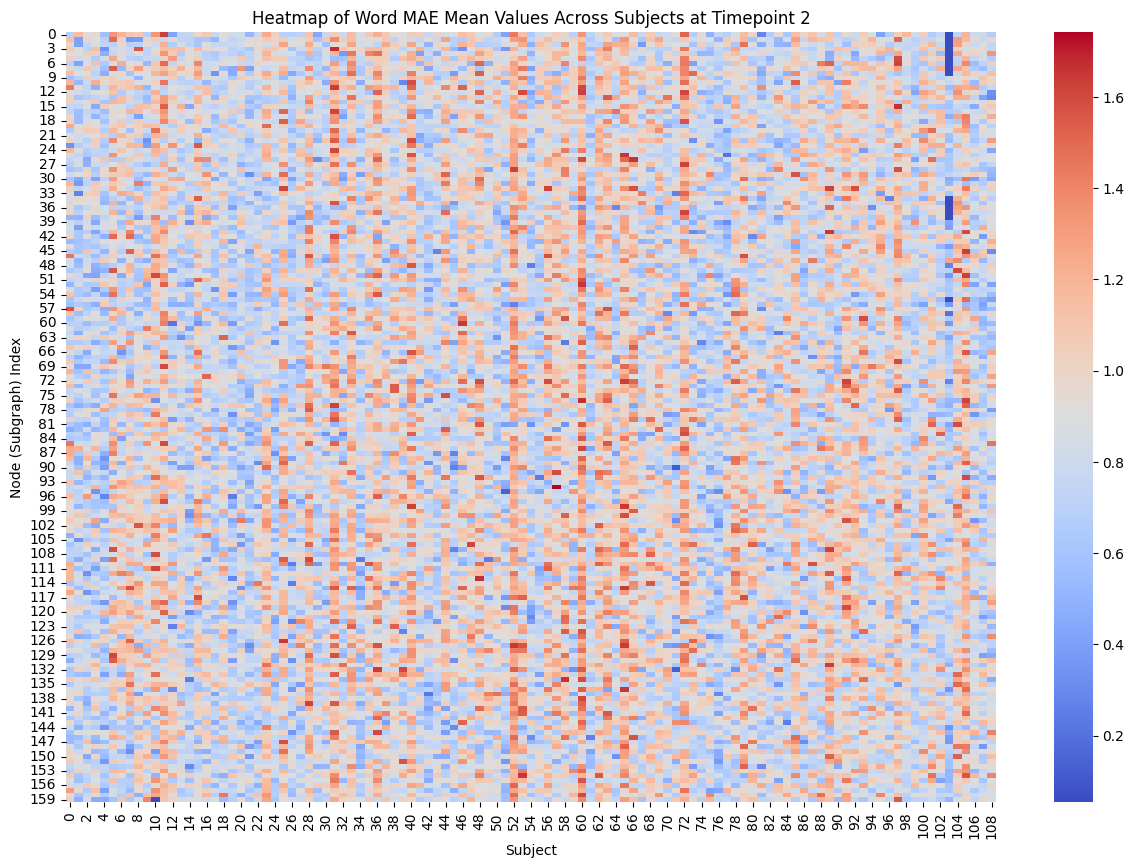

In [36]:
filtered_df = subgraphs_mae_df[subgraphs_mae_df['Timepoint'] == 0]
mean_mae_pivot = filtered_df.pivot_table(index='Subgraph_Index', columns='Subject', values='Word_MAE', aggfunc='mean')
plt.figure(figsize=(15, 10))
sns.heatmap(mean_mae_pivot, annot=False, cmap='coolwarm')
plt.title(f'Heatmap of Word MAE Mean Values Across Subjects at Timepoint {0}')
plt.xlabel('Subject')
plt.ylabel('Node (Subgraph) Index')
plt.show()

filtered_df = subgraphs_mae_df[subgraphs_mae_df['Timepoint'] == 1]
mean_mae_pivot = filtered_df.pivot_table(index='Subgraph_Index', columns='Subject', values='Word_MAE', aggfunc='mean')
plt.figure(figsize=(15, 10))
sns.heatmap(mean_mae_pivot, annot=False, cmap='coolwarm')
plt.title(f'Heatmap of Word MAE Mean Values Across Subjects at Timepoint {1}')
plt.xlabel('Subject')
plt.ylabel('Node (Subgraph) Index')
plt.show()

filtered_df = subgraphs_mae_df[subgraphs_mae_df['Timepoint'] == 2]
mean_mae_pivot = filtered_df.pivot_table(index='Subgraph_Index', columns='Subject', values='Word_MAE', aggfunc='mean')
plt.figure(figsize=(15, 10))
sns.heatmap(mean_mae_pivot, annot=False, cmap='coolwarm')
plt.title(f'Heatmap of Word MAE Mean Values Across Subjects at Timepoint {2}')
plt.xlabel('Subject')
plt.ylabel('Node (Subgraph) Index')
plt.show()


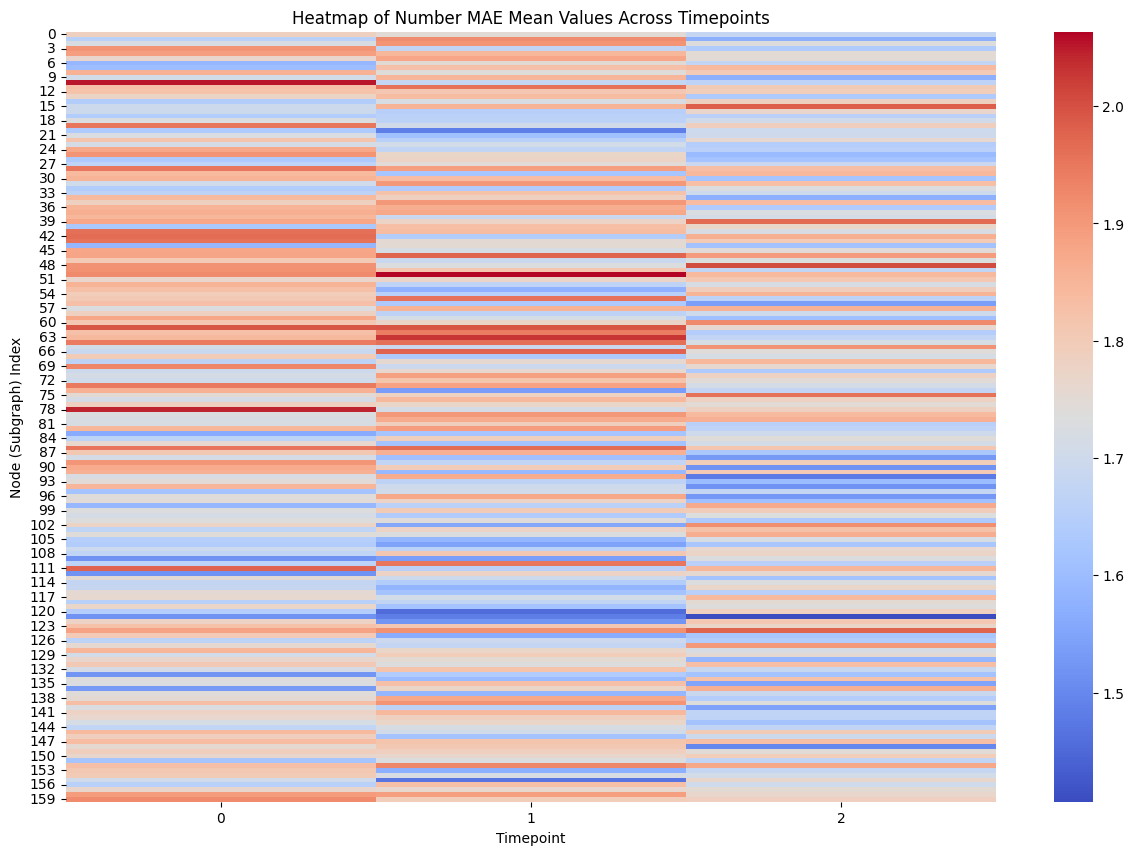

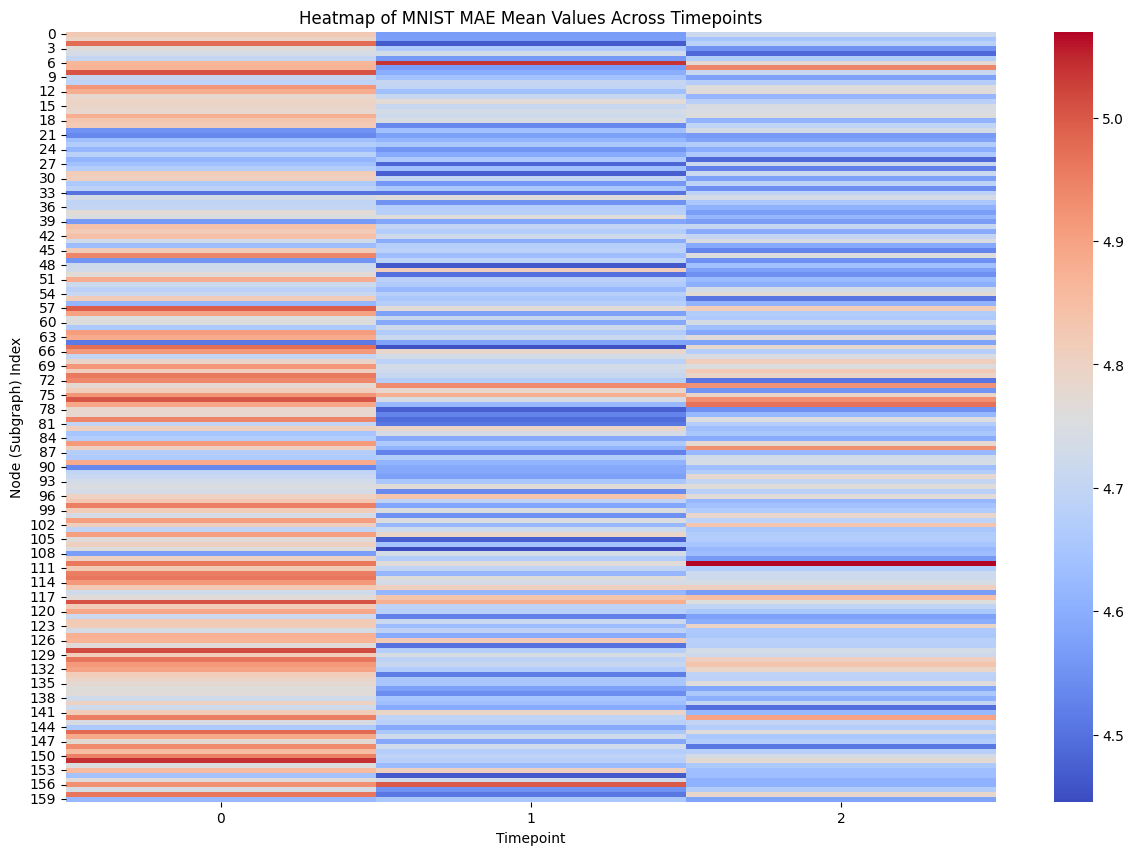

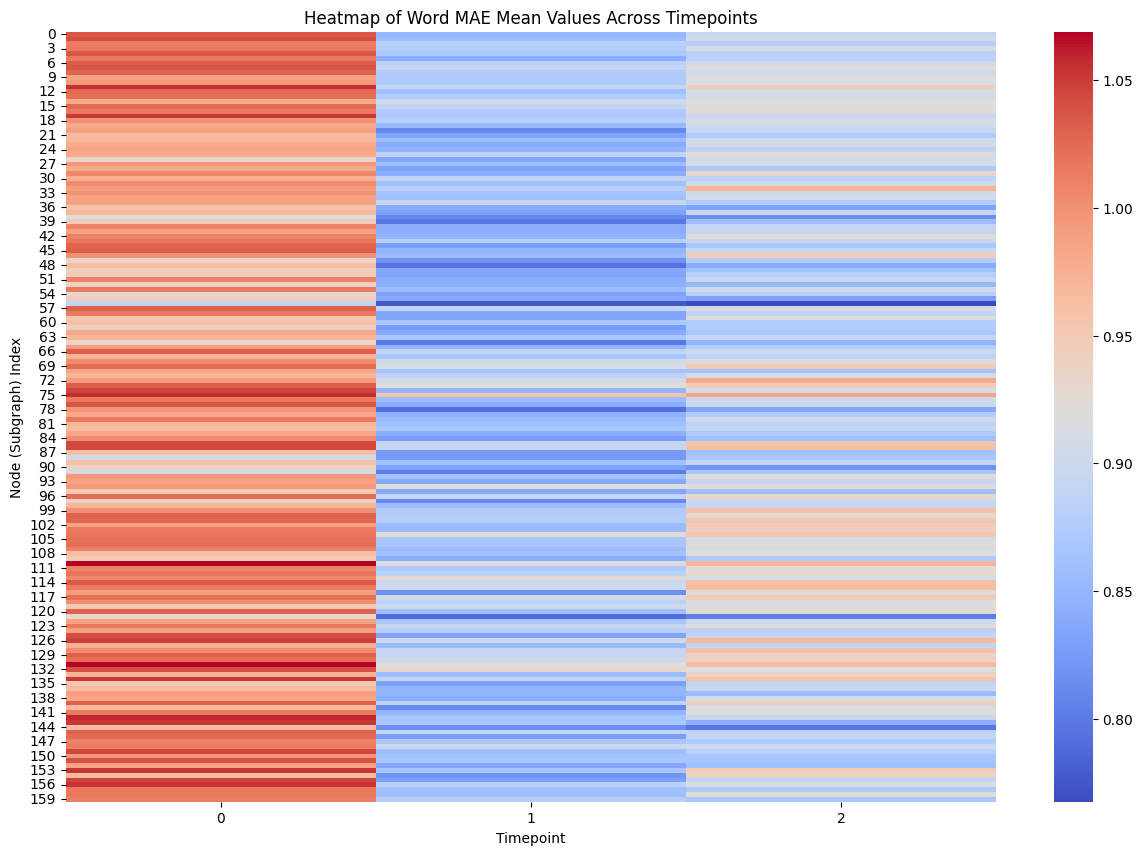

In [37]:
mean_mae_pivot = subgraphs_mae_df.pivot_table(index='Subgraph_Index', columns='Timepoint', values='Number_MAE', aggfunc='mean')
plt.figure(figsize=(15, 10))
sns.heatmap(mean_mae_pivot, annot=False, cmap='coolwarm')
plt.title('Heatmap of Number MAE Mean Values Across Timepoints')
plt.xlabel('Timepoint')
plt.ylabel('Node (Subgraph) Index')
plt.show()

mean_mae_pivot = subgraphs_mae_df.pivot_table(index='Subgraph_Index', columns='Timepoint', values='MNIST_MAE', aggfunc='mean')
plt.figure(figsize=(15, 10))
sns.heatmap(mean_mae_pivot, annot=False, cmap='coolwarm')
plt.title('Heatmap of MNIST MAE Mean Values Across Timepoints')
plt.xlabel('Timepoint')
plt.ylabel('Node (Subgraph) Index')
plt.show()

mean_mae_pivot = subgraphs_mae_df.pivot_table(index='Subgraph_Index', columns='Timepoint', values='Word_MAE', aggfunc='mean')
plt.figure(figsize=(15, 10))
sns.heatmap(mean_mae_pivot, annot=False, cmap='coolwarm')
plt.title('Heatmap of Word MAE Mean Values Across Timepoints')
plt.xlabel('Timepoint')
plt.ylabel('Node (Subgraph) Index')
plt.show()


In [48]:
import numpy as np
import pandas as pd

# Define the specific timepoint (e.g., t = 0)
timepoint = 0

# Extract the adjacency matrices for the specific timepoint
adj_matrices = slim160_cleaned[:, timepoint, :, :]

# Filter the DataFrame for the specific timepoint and task (e.g., Word_MAE)
filtered_df = subgraphs_mae_df[subgraphs_mae_df['Timepoint'] == timepoint][['Subject', 'Subgraph_Index', 'Word_MAE']]

# Initialize lists to store the results
node_means = []
neighbor_means = []
neighbor_stds = []
mae_difference = []

# Calculate the mean and std of MAE values for each node and its neighbors
for subject_idx in range(adj_matrices.shape[0]):
    subject_df = filtered_df[filtered_df['Subject'] == subject_idx]
    adjacency_matrix = adj_matrices[subject_idx]
    
    for node_idx in range(adjacency_matrix.shape[0]):
        node_mae = subject_df[subject_df['Subgraph_Index'] == node_idx]['Word_MAE'].values[0]
        
        # Identify the neighbors
        neighbors = np.where(adjacency_matrix[node_idx] != 0)[0]
        neighbor_maes = subject_df[subject_df['Subgraph_Index'].isin(neighbors)]['Word_MAE'].values
        
        node_means.append(node_mae)
        neighbor_means.append(np.mean(neighbor_maes))
        neighbor_stds.append(np.std(neighbor_maes))
        mae_difference.append(node_mae-np.mean(neighbor_maes))

# Create a DataFrame to store the results
neighbor_analysis_df = pd.DataFrame({
    'Node_MAE': node_means,
    'Neighbor_Mean_MAE': neighbor_means,
    'Neighbor_Std_MAE': neighbor_stds,
    'Node_vs_Neighbour_MAE': mae_difference
})


In [49]:
# Display the first few rows of the DataFrame
neighbor_analysis_df

,Node_MAE,Neighbor_Mean_MAE,Neighbor_Std_MAE,Node_vs_Neighbour_MAE
0,1.053054,1.056611,0.256730,-0.003557
1,0.913534,1.055966,0.245479,-0.142432
2,0.649255,1.046742,0.242141,-0.397487
3,1.061533,1.061227,0.245657,0.000306
4,1.280242,1.070522,0.248894,0.209720
...,...,...,...,...
17435,1.081694,1.030340,0.199733,0.051354
17436,1.156580,1.002577,0.214978,0.154003
17437,0.707037,0.997362,0.218285,-0.290325
17438,0.842465,1.018312,0.213309,-0.175846


In [51]:
print('Min Difference: ', neighbor_analysis_df['Node_vs_Neighbour_MAE'].min())
print('Max Difference: ', neighbor_analysis_df['Node_vs_Neighbour_MAE'].max())
print('Mean Difference: ', neighbor_analysis_df['Node_vs_Neighbour_MAE'].mean())
print('std Difference: ', neighbor_analysis_df['Node_vs_Neighbour_MAE'].std())

Min Difference:  -0.795102733421947
Max Difference:  0.7854778344259696
Mean Difference:  -0.013176939333023907
std Difference:  0.2079530486933903


#### SLIM Dataset

In [58]:
def calculate_cognitive_capacity(dataset, num_nodes):
    # Initialize and test ESNs for each graph in the dataset
    mae_results = []
    reservoir_size = num_nodes

    for subject in range(dataset.shape[0]):
        subject_mae = []
        for timepoint in range(dataset.shape[1]):
            adjacency_matrix = dataset[subject, timepoint]
            
            # Calculate MAE for number sequence
            Win, Wres, Wout = initialize_esn(adjacency_matrix, input_size=1, reservoir_size=reservoir_size, output_size=1)
            number_mae = calculate_mae(Win, Wres, Wout, number_sequence, number_target)
            
            # Calculate MAE for MNIST sequence
            Win, Wres, Wout = initialize_esn(adjacency_matrix, input_size=28*28, reservoir_size=reservoir_size, output_size=1)
            mnist_mae = calculate_mae(Win, Wres, Wout, mnist_input, mnist_target)
            
            # Calculate MAE for Word2Vec sequence
            Win, Wres, Wout = initialize_esn(adjacency_matrix, input_size=10, reservoir_size=reservoir_size, output_size=10)
            word_mae = calculate_mae(Win, Wres, Wout, word_input, word_target)
            
            subject_mae.append((number_mae, mnist_mae, word_mae))
        mae_results.append(subject_mae)

    # Convert results to a DataFrame for easier manipulation
    mae_df = pd.DataFrame(mae_results, columns=['Timepoint_1', 'Timepoint_2', 'Timepoint_3'])
    mae_df[['Number_MAE_1', 'MNIST_MAE_1', 'Word_MAE_1']] = pd.DataFrame(mae_df['Timepoint_1'].tolist())
    mae_df[['Number_MAE_2', 'MNIST_MAE_2', 'Word_MAE_2']] = pd.DataFrame(mae_df['Timepoint_2'].tolist())
    mae_df[['Number_MAE_3', 'MNIST_MAE_3', 'Word_MAE_3']] = pd.DataFrame(mae_df['Timepoint_3'].tolist())
    mae_df.drop(columns=['Timepoint_1', 'Timepoint_2', 'Timepoint_3'], inplace=True)

    # Calculate mean, max, min for each timepoint
    mean_mae = mae_df.mean()
    std_mae = mae_df.std()
    max_mae = mae_df.max()
    min_mae = mae_df.min()

    return mae_df, mean_mae, std_mae, max_mae, min_mae

def calculate_cognitive_delta(mae_df):
    tasks = ['Number', 'MNIST', 'Word']
    delta_df = pd.DataFrame()

    for task in tasks:
        delta_df[f'{task}_Delta_1_2'] = mae_df[f'{task}_MAE_2'] - mae_df[f'{task}_MAE_1']
        delta_df[f'{task}_Delta_2_3'] = mae_df[f'{task}_MAE_3'] - mae_df[f'{task}_MAE_2']
    
    mean_delta_df = delta_df.mean()
    std_delta_df = delta_df.std()
    max_delta_df = delta_df.max()
    min_delta_df = delta_df.min()

    return delta_df, mean_delta_df, std_delta_df, max_delta_df, min_delta_df


slim160_mae_df, slim160_mean_mae,  slim160_std_mae, slim160_max_mae, slim160_min_mae = calculate_cognitive_capacity(slim160_cleaned, 160)
slim160_delta_df, slim160_mean_delta, slim160_std_delta, slim160_max_delta, slim160_min_delta = calculate_cognitive_delta(slim160_mae_df)

In [69]:
slim160_mae_df

,Number_MAE_1,MNIST_MAE_1,Word_MAE_1,Number_MAE_2,MNIST_MAE_2,Word_MAE_2,Number_MAE_3,MNIST_MAE_3,Word_MAE_3
0,2.607454,8.499401,1.492433,0.739591,8.527621,1.129976,0.738311,8.517040,1.191581
1,0.738963,8.525639,1.001573,0.739975,8.552545,1.067561,0.740149,8.540360,1.132126
2,0.743241,8.539582,1.278147,0.740716,8.512619,1.015738,0.739584,8.537555,1.132834
3,0.738981,8.535776,1.347190,0.739417,8.523161,1.108007,0.738485,8.541521,1.136594
4,0.739309,8.531648,1.379876,0.744942,8.513888,1.135011,0.739893,8.529463,0.700006
...,...,...,...,...,...,...,...,...,...
104,0.740562,8.525929,1.290189,0.738846,8.527158,1.028246,0.739827,8.529603,1.189952
105,0.741764,8.518014,1.044538,0.739915,8.549947,0.653081,0.734478,8.523092,1.190072
106,0.737883,8.520581,1.033511,0.739654,8.524372,1.076402,0.740311,8.557347,0.888300
107,0.738674,8.523106,1.248406,0.739887,8.540576,1.214199,0.738545,8.539492,1.037806


#### Maturation Dataset

In [55]:
def calculate_cognitive_capacity_new_format(dataset, num_nodes):
    
    # Initialize and test ESNs for each graph in the dataset
    mae_results = []
    reservoir_size = num_nodes

    for subject in range(dataset.shape[0]):
        subject_mae = []
        adjacency_matrix = dataset[subject, 0]  # Since tl is always 1, we use 0 index
        timelabel_arr = dataset[subject,:,0,0]
        timelabel = int(timelabel_arr[0])
        # print(timelabel)

        # Calculate MAE for number sequence
        Win, Wres, Wout = initialize_esn(adjacency_matrix, input_size=1, reservoir_size=reservoir_size, output_size=1)
        number_mae = calculate_mae(Win, Wres, Wout, number_sequence, number_target)

        # Calculate MAE for MNIST sequence
        Win, Wres, Wout = initialize_esn(adjacency_matrix, input_size=28*28, reservoir_size=reservoir_size, output_size=1)
        mnist_mae = calculate_mae(Win, Wres, Wout, mnist_input, mnist_target)

        # Calculate MAE for Word2Vec sequence
        Win, Wres, Wout = initialize_esn(adjacency_matrix, input_size=10, reservoir_size=reservoir_size, output_size=10)
        word_mae = calculate_mae(Win, Wres, Wout, word_input, word_target)

        subject_mae.append((timelabel, number_mae, mnist_mae, word_mae))
        mae_results.append(subject_mae[0])

    # Convert results to a DataFrame for easier manipulation
    mae_df = pd.DataFrame(mae_results, columns=['Timelabel', 'Number_MAE', 'MNIST_MAE', 'Word_MAE'])

    # Calculate mean, std, max, min for each timelabel and each task
    mean_mae = mae_df.groupby('Timelabel').mean()
    std_mae = mae_df.groupby('Timelabel').std()
    max_mae = mae_df.groupby('Timelabel').max()
    min_mae = mae_df.groupby('Timelabel').min()

    return mae_df, mean_mae, std_mae, max_mae, min_mae

In [56]:
mature_mae_df, mature_mean_mae, mature_std_mae, mature_max_mae, mature_min_mae = calculate_cognitive_capacity_new_format(transformed_and_filtered_data, 300)

In [67]:
mature_mean_mae.mean()

Number_MAE    3.451280
MNIST_MAE     5.580431
Word_MAE      1.628013
dtype: float64

## Data Visualization

### Slim160 Dataset

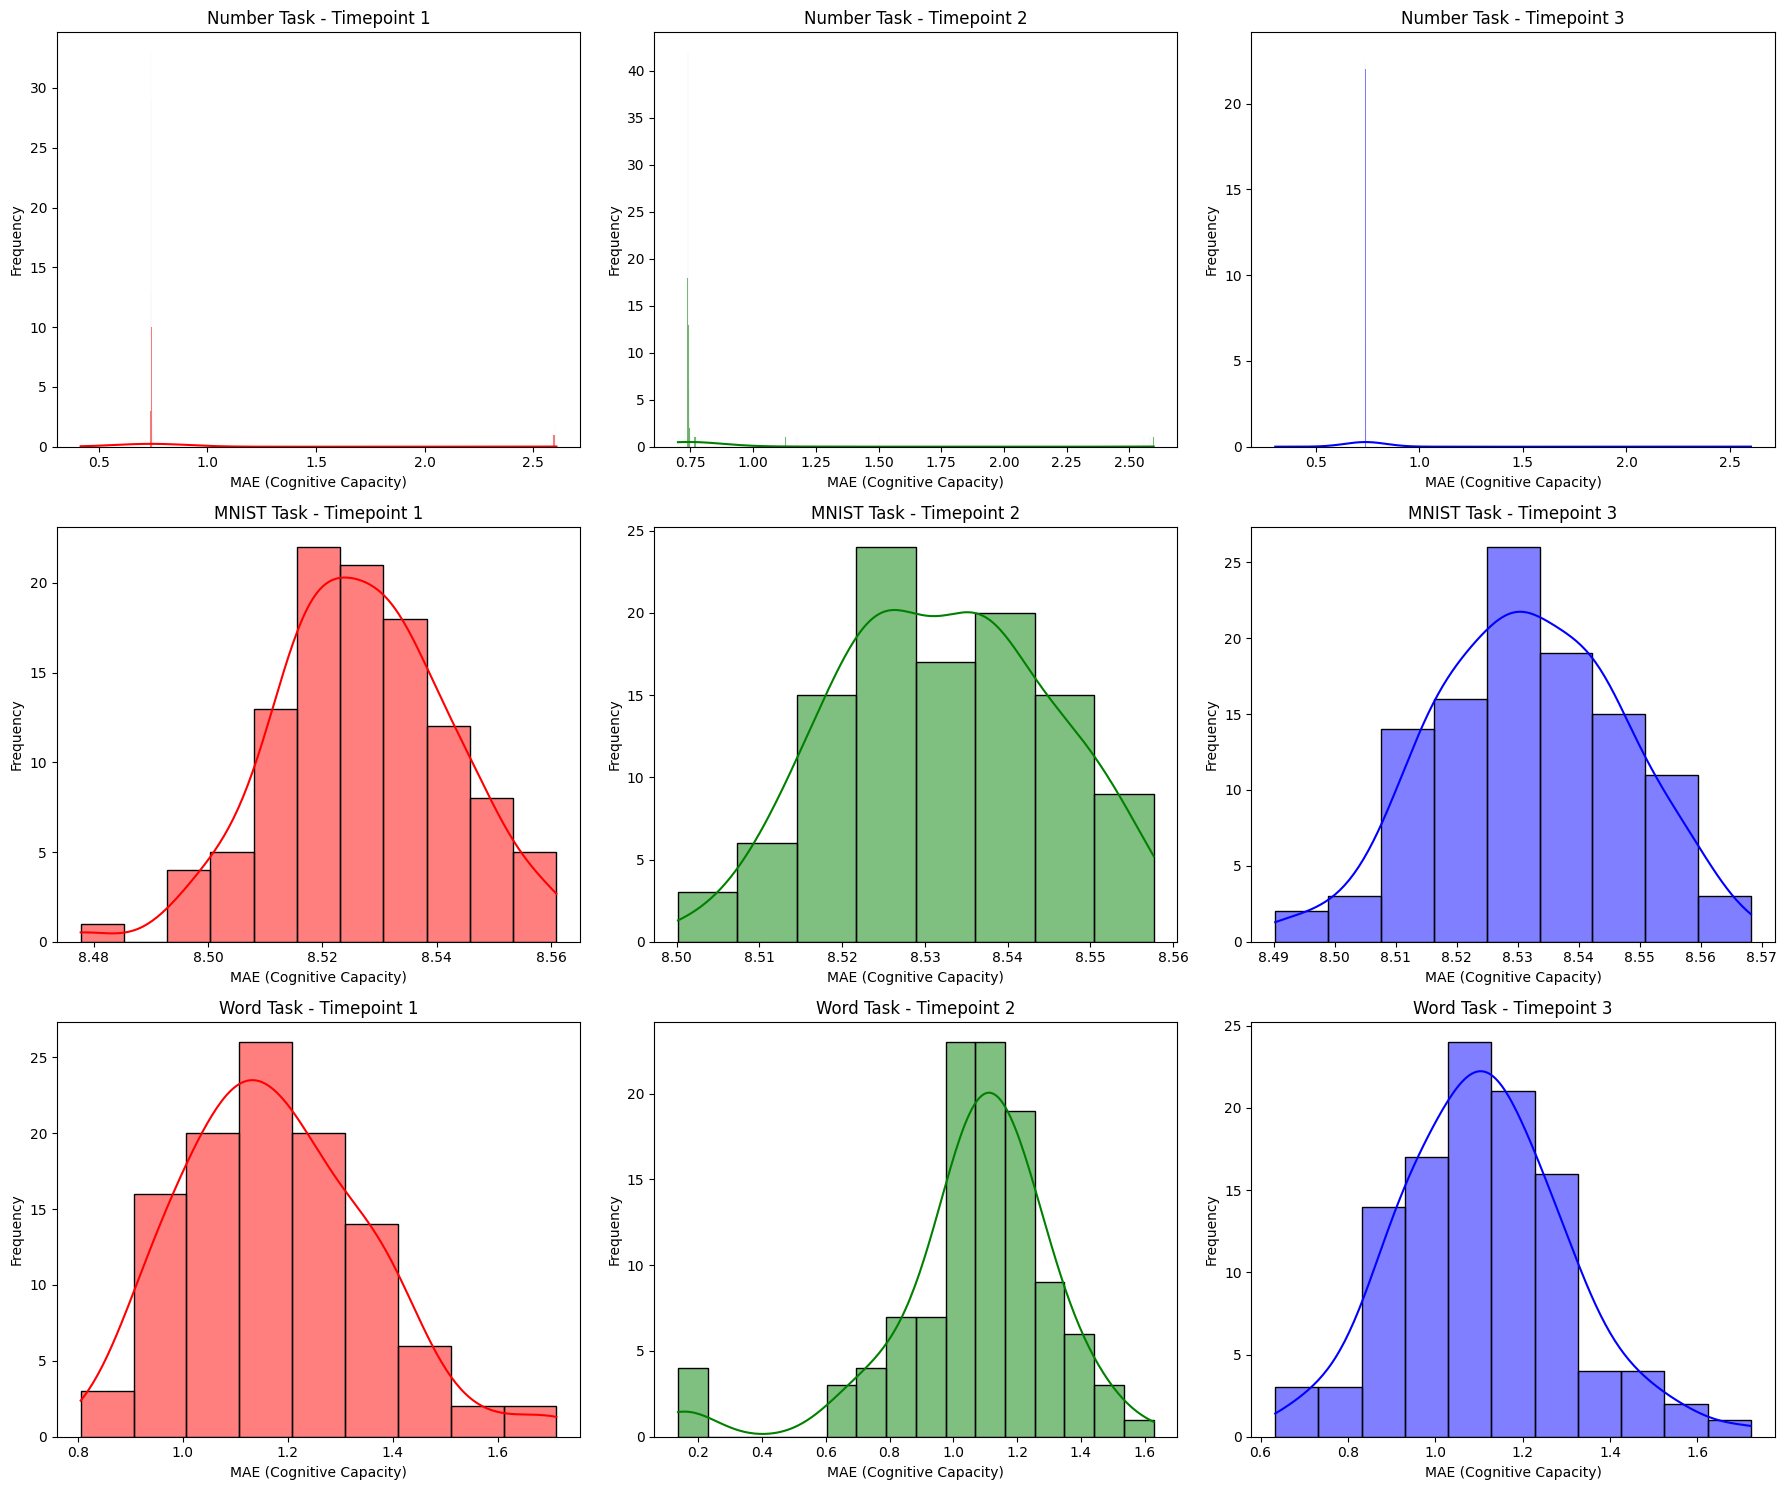

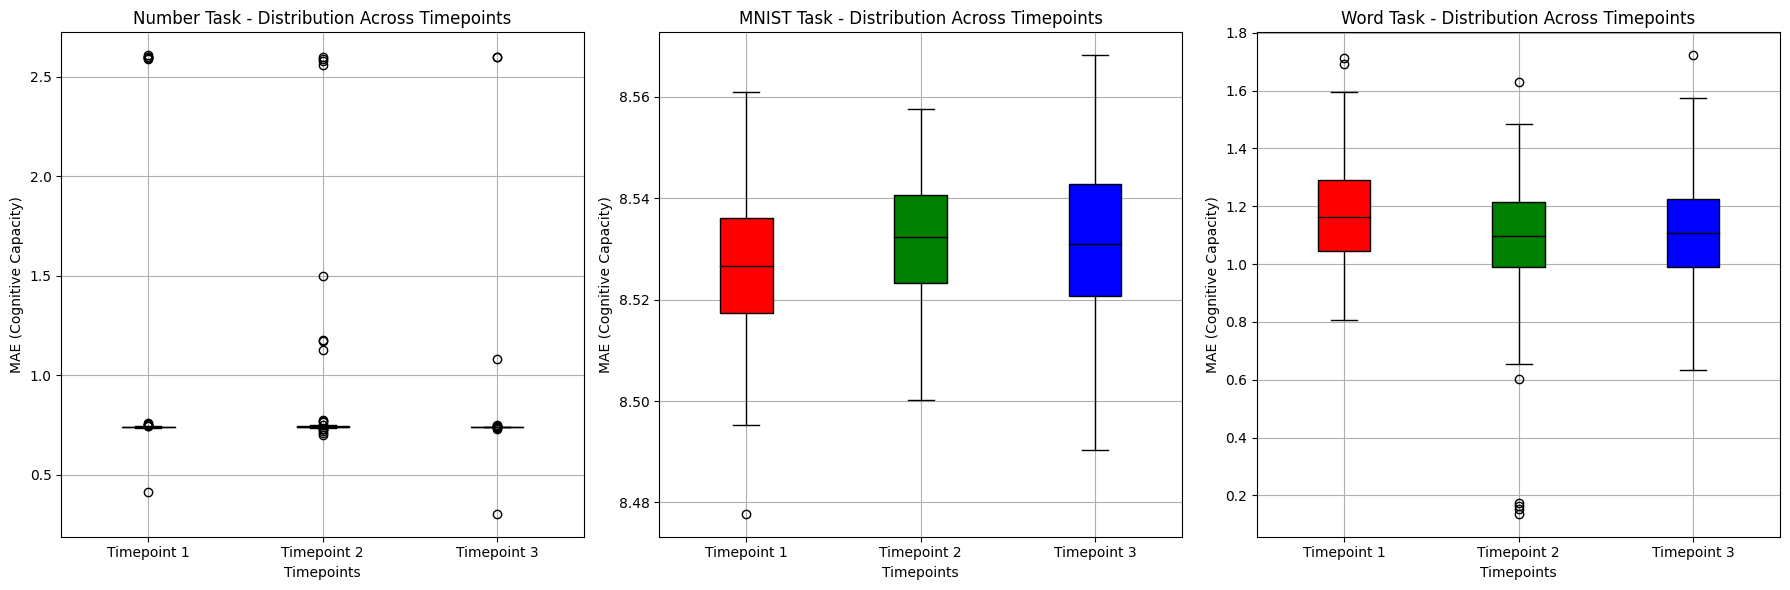

In [61]:
def cognitive_distribution_viz(mae_df):
    # Define colors for each timepoint
    colors = ['red', 'green', 'blue']

    # Plot the cognitive capacity (MAE) distribution from each task and each timepoint
    fig, axs = plt.subplots(3, 3, figsize=(18, 15))
    tasks = ['Number', 'MNIST', 'Word']
    timepoints = ['Timepoint 1', 'Timepoint 2', 'Timepoint 3']

    for i, task in enumerate(tasks):
        for j, timepoint in enumerate(timepoints):
            data = mae_df[f'{task}_MAE_{j+1}']
            sns.histplot(data, kde=True, ax=axs[i, j], color=colors[j])
            axs[i, j].set_title(f'{task} Task - {timepoint}')
            axs[i, j].set_xlabel('MAE (Cognitive Capacity)')
            axs[i, j].set_ylabel('Frequency')
            axs[i, j].grid(False)
            

    plt.tight_layout()
    plt.show()

    # Plot the distribution of cognitive property (memory capacity) using box plots
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    for i, task in enumerate(tasks):
        data_to_plot = [mae_df[f'{task}_MAE_{j+1}'] for j in range(3)]
        box = axs[i].boxplot(data_to_plot, patch_artist=True, medianprops=dict(color='black'))
        
        # Set the face color for each box
        for patch, color in zip(box['boxes'], colors):
            patch.set_facecolor(color)
        
        axs[i].set_title(f'{task} Task - Distribution Across Timepoints')
        axs[i].set_xticks([1, 2, 3])
        axs[i].set_xticklabels(timepoints)
        axs[i].set_xlabel('Timepoints')
        axs[i].set_ylabel('MAE (Cognitive Capacity)')
        axs[i].grid(True)

    plt.tight_layout()
    plt.show()

def cognitive_delta_viz(delta_df):
    # Define colors for each timepoint
    colors = ['pink', 'lightgreen', 'lightblue']
    tasks = ['Number', 'MNIST', 'Word']

    fig, axs = plt.subplots(2, 3, figsize=(18, 10))
    for i, task in enumerate(tasks):
        sns.histplot(delta_df[f'{task}_Delta_1_2'], kde=True, ax=axs[0, i], color='purple')
        axs[0, i].set_title(f'{task} Task - Delta Timepoint 1 to 2')
        axs[0, i].set_xlabel('Delta Cognitive Capacity (MAE)')
        axs[0, i].set_ylabel('Frequency')
        axs[0, i].grid(True)

        sns.histplot(delta_df[f'{task}_Delta_2_3'], kde=True, ax=axs[1, i], color='orange')
        axs[1, i].set_title(f'{task} Task - Delta Timepoint 2 to 3')
        axs[1, i].set_xlabel('Delta Cognitive Capacity (MAE)')
        axs[1, i].set_ylabel('Frequency')
        axs[1, i].grid(True)

    plt.tight_layout()
    plt.show()
    return


cognitive_distribution_viz(slim160_mae_df)

In [121]:
print('Mean MAE')
print(slim160_mean_mae.sort_index())

print('\nStd MAE')
print(slim160_std_mae.sort_index())

print('\nMin MAE') 
print(slim160_min_mae.sort_index())

print('\nMax MAE') 
print(slim160_max_mae.sort_index())

Mean MAE
MNIST_MAE_1     8.526956
MNIST_MAE_2     8.532224
MNIST_MAE_3     8.531683
Number_MAE_1    0.839956
Number_MAE_2    0.826687
Number_MAE_3    0.773437
Word_MAE_1      1.176701
Word_MAE_2      1.065565
Word_MAE_3      1.109190
dtype: float64

Std MAE
MNIST_MAE_1     0.015140
MNIST_MAE_2     0.012825
MNIST_MAE_3     0.015405
Number_MAE_1    0.427552
Number_MAE_2    0.358046
Number_MAE_3    0.256479
Word_MAE_1      0.175698
Word_MAE_2      0.257584
Word_MAE_3      0.192052
dtype: float64

Min MAE
MNIST_MAE_1     8.477756
MNIST_MAE_2     8.500168
MNIST_MAE_3     8.490252
Number_MAE_1    0.415864
Number_MAE_2    0.700303
Number_MAE_3    0.304889
Word_MAE_1      0.805688
Word_MAE_2      0.136529
Word_MAE_3      0.633725
dtype: float64

Max MAE
MNIST_MAE_1     8.560923
MNIST_MAE_2     8.557641
MNIST_MAE_3     8.568213
Number_MAE_1    2.607454
Number_MAE_2    2.597250
Number_MAE_3    2.600651
Word_MAE_1      1.711332
Word_MAE_2      1.628238
Word_MAE_3      1.722391
dtype: float64


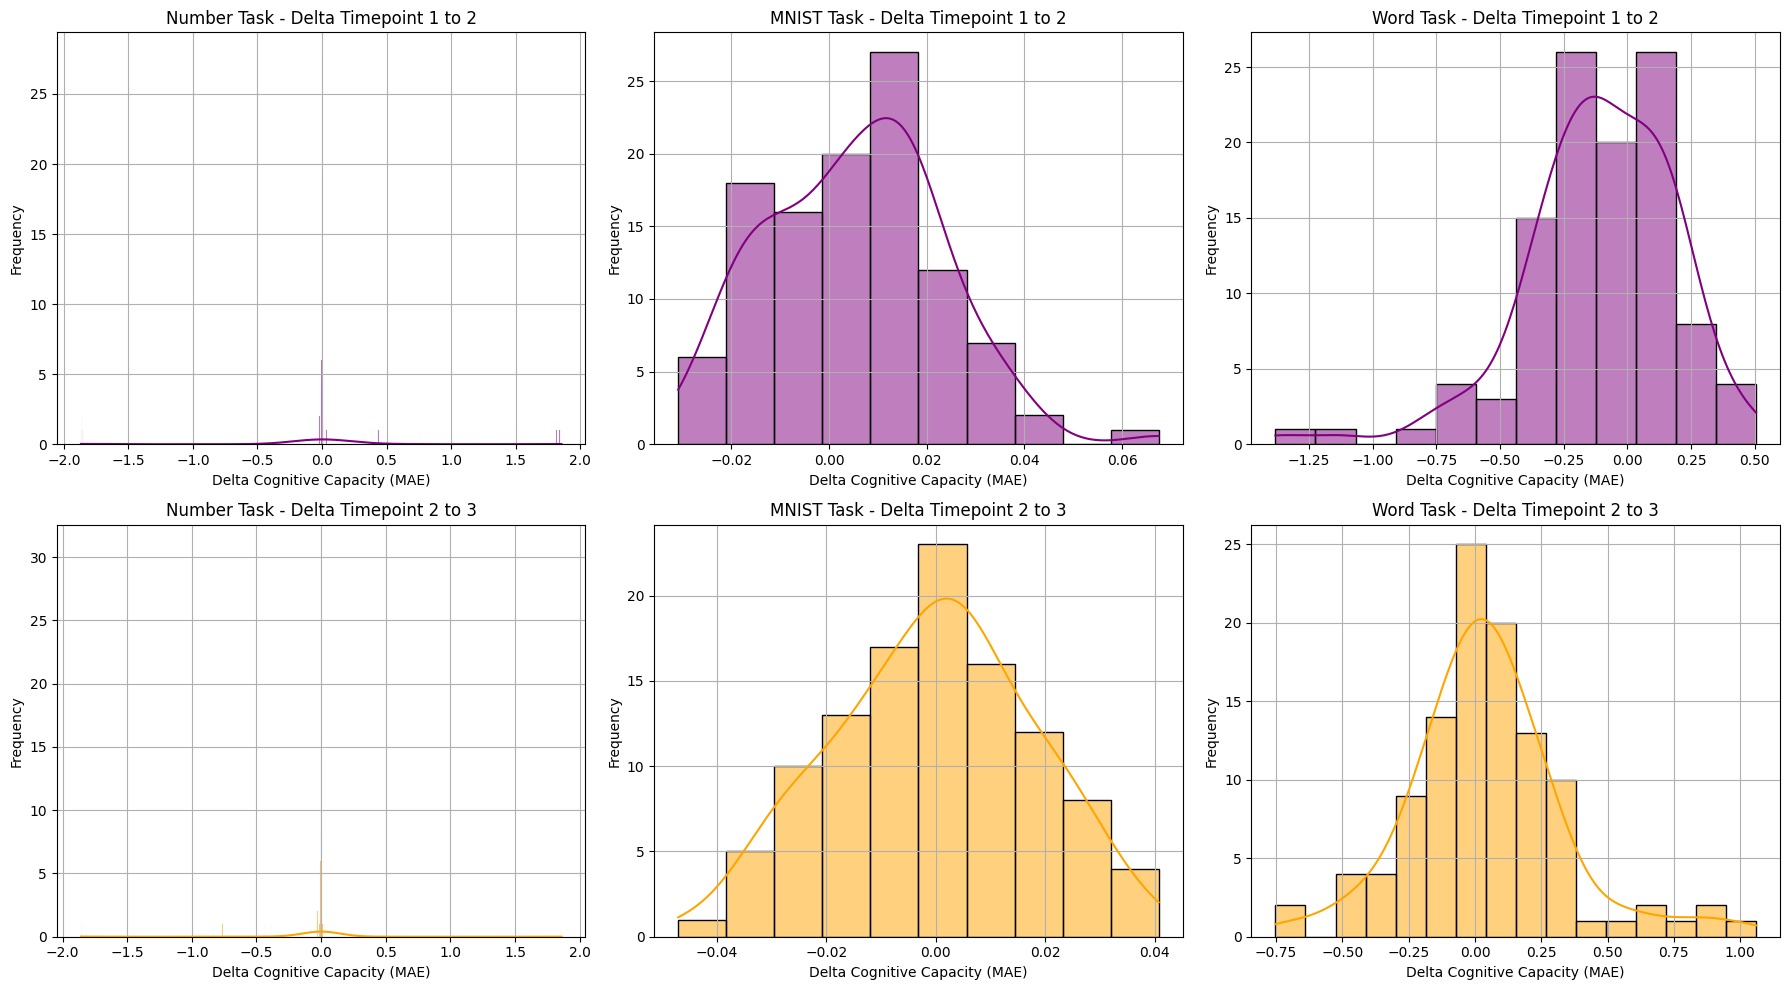

In [123]:
cognitive_delta_viz(slim160_delta_df)

In [122]:
print('Mean MAE Change Overtime')
print(slim160_mean_delta.sort_index())

print('\nStd MAE Change Overtime')
print(slim160_std_delta.sort_index())

print('\nMin MAE Change Overtime') 
print(slim160_min_delta.sort_index())

print('\nMax MAE Change Overtime') 
print(slim160_max_delta.sort_index())

Mean MAE Change Overtime
MNIST_Delta_1_2     0.005268
MNIST_Delta_2_3    -0.000540
Number_Delta_1_2   -0.013268
Number_Delta_2_3   -0.053250
Word_Delta_1_2     -0.111136
Word_Delta_2_3      0.043626
dtype: float64

Std MAE Change Overtime
MNIST_Delta_1_2     0.017742
MNIST_Delta_2_3     0.018261
Number_Delta_1_2    0.572999
Number_Delta_2_3    0.374299
Word_Delta_1_2      0.299810
Word_Delta_2_3      0.292227
dtype: float64

Min MAE Change Overtime
MNIST_Delta_1_2    -0.030864
MNIST_Delta_2_3    -0.047080
Number_Delta_1_2   -1.867863
Number_Delta_2_3   -1.858182
Word_Delta_1_2     -1.381562
Word_Delta_2_3     -0.752534
dtype: float64

Max MAE Change Overtime
MNIST_Delta_1_2     0.067507
MNIST_Delta_2_3     0.040710
Number_Delta_1_2    1.855311
Number_Delta_2_3    1.859078
Word_Delta_1_2      0.504456
Word_Delta_2_3      1.060053
dtype: float64


### Maturation Dataset

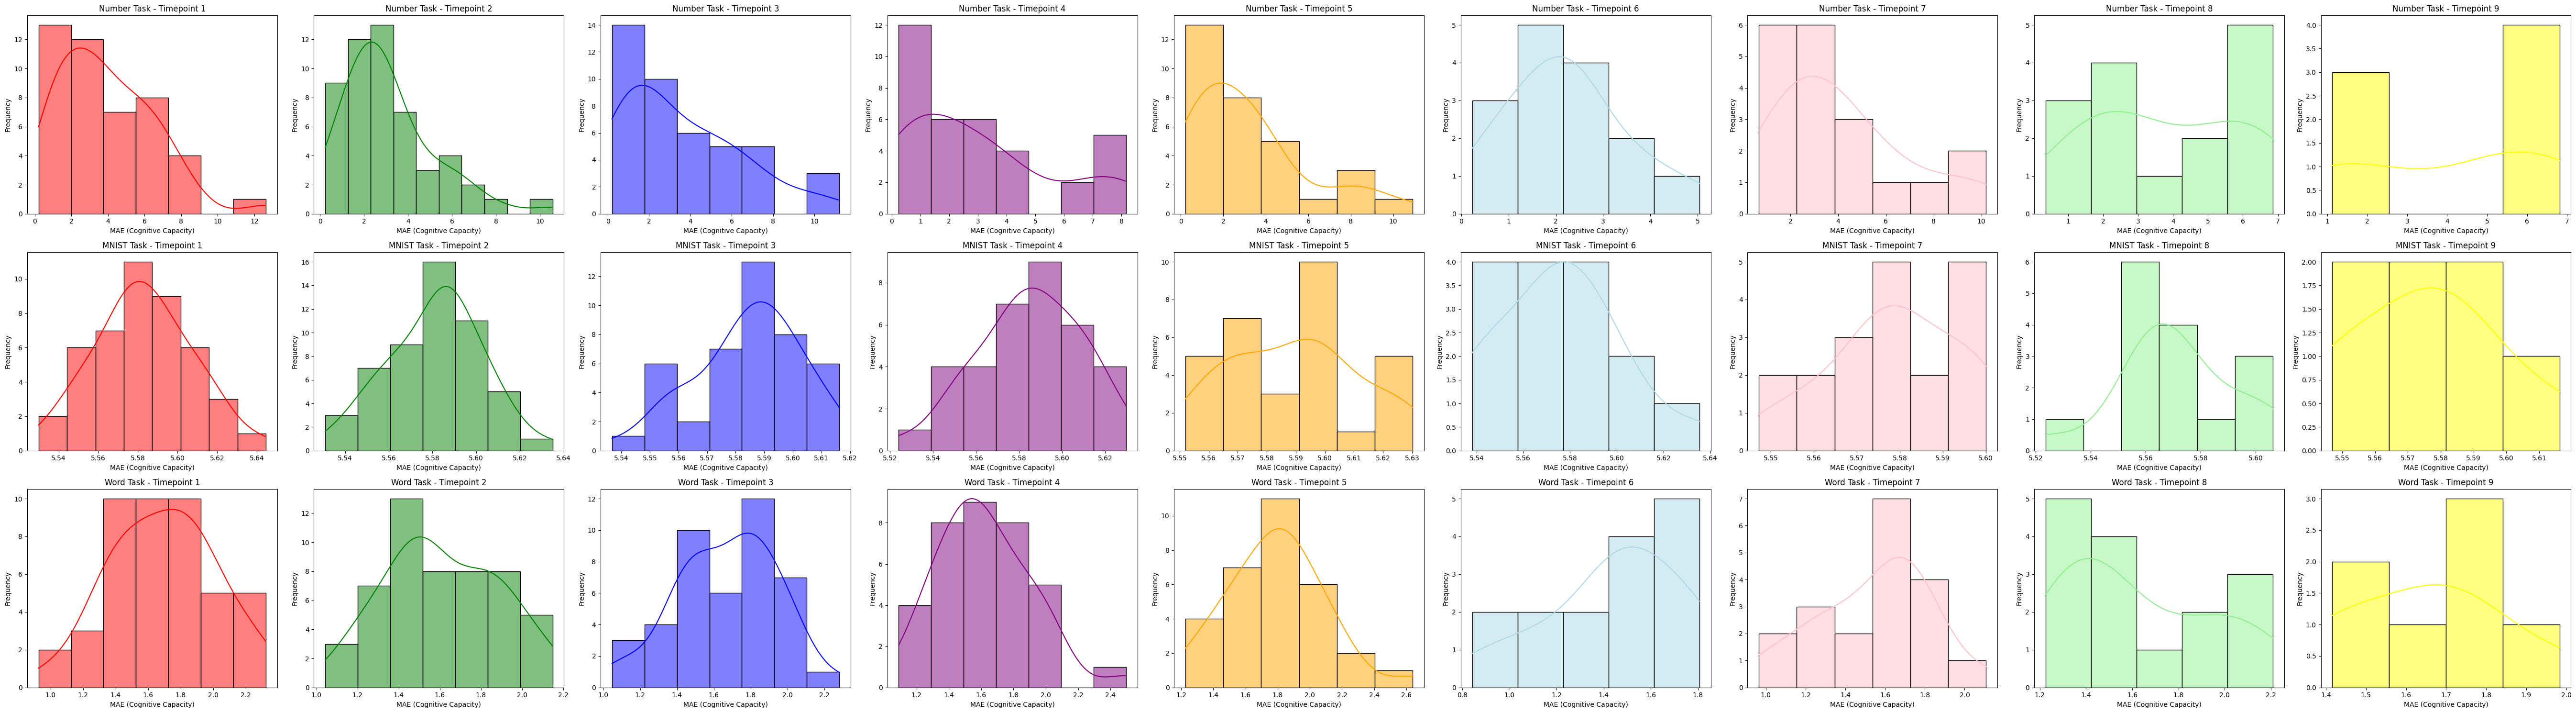

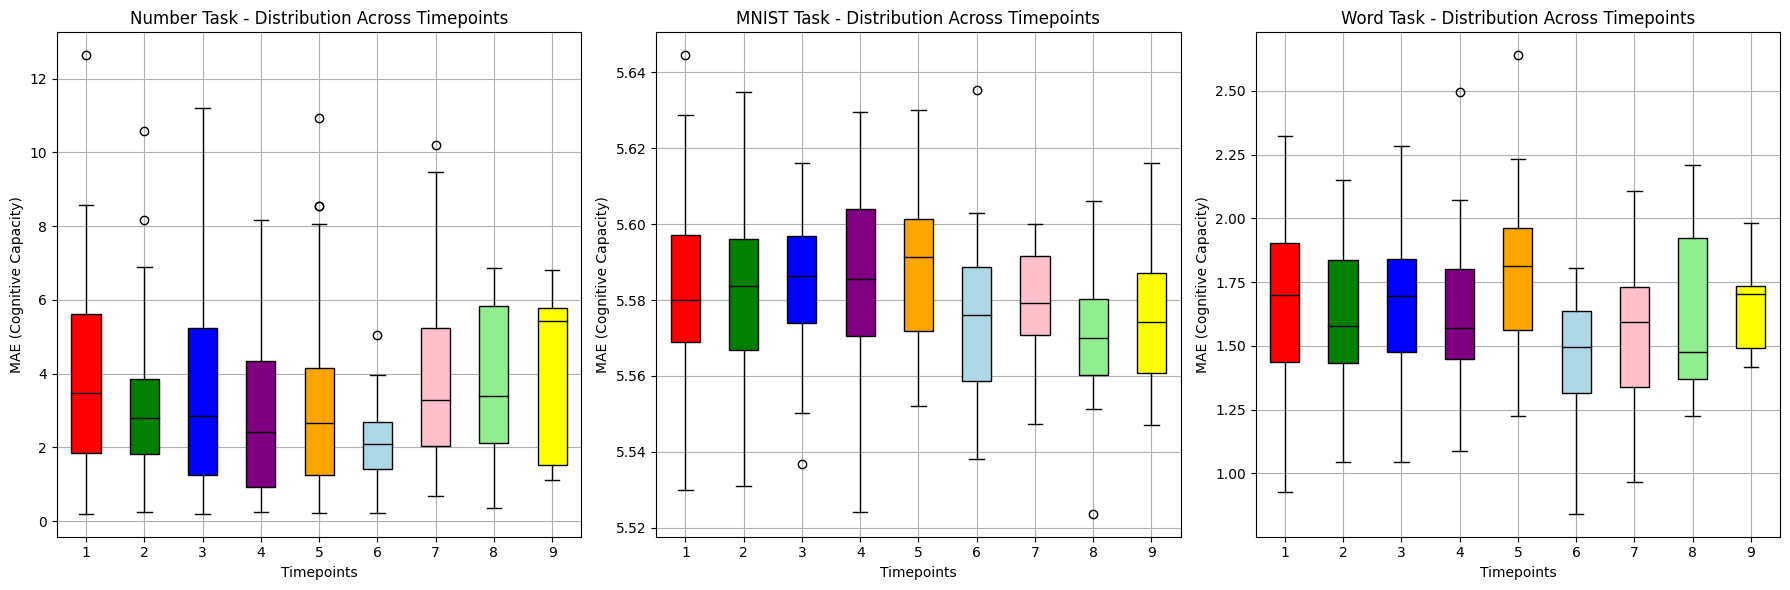

In [64]:
def cognitive_distribution_viz_new(mae_df):
    # Define colors for each timepoint
    colors = ['red', 'green', 'blue', 'purple', 'orange', 'lightblue', 'pink', 'lightgreen', 'yellow']

    # Get unique timelabels and map them to colors
    timelabels = sorted(mae_df['Timelabel'].unique())
    color_map = dict(zip(timelabels, colors[:len(timelabels)]))

    # Plot the cognitive capacity (MAE) distribution from each task and each timepoint
    fig, axs = plt.subplots(3, len(timelabels), figsize=(6 * len(timelabels), 15))
    tasks = ['Number', 'MNIST', 'Word']

    for i, task in enumerate(tasks):
        for j, timelabel in enumerate(timelabels):
            data = mae_df[mae_df['Timelabel'] == timelabel][f'{task}_MAE']
            sns.histplot(data, kde=True, ax=axs[i, j], color=color_map[timelabel])
            axs[i, j].set_title(f'{task} Task - Timepoint {timelabel}')
            axs[i, j].set_xlabel('MAE (Cognitive Capacity)')
            axs[i, j].set_ylabel('Frequency')
            axs[i, j].grid(False)

    plt.tight_layout()
    plt.show()

    # Plot the distribution of cognitive property (memory capacity) using box plots
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    for i, task in enumerate(tasks):
        data_to_plot = [mae_df[mae_df['Timelabel'] == timelabel][f'{task}_MAE'] for timelabel in timelabels]
        box = axs[i].boxplot(data_to_plot, patch_artist=True, medianprops=dict(color='black'))
        
        # Set the face color for each box
        for patch, timelabel in zip(box['boxes'], timelabels):
            patch.set_facecolor(color_map[timelabel])
        
        axs[i].set_title(f'{task} Task - Distribution Across Timepoints')
        axs[i].set_xticks(range(1, len(timelabels) + 1))
        axs[i].set_xticklabels([f'{tl}' for tl in timelabels])
        axs[i].set_xlabel('Timepoints')
        axs[i].set_ylabel('MAE (Cognitive Capacity)')
        axs[i].grid(True)

    plt.tight_layout()
    plt.show()

cognitive_distribution_viz_new(mature_mae_df)

In [ ]:
print('Mean MAE')
print(slim160_mean_mae.sort_index())

print('\nStd MAE')
print(slim160_std_mae.sort_index())

print('\nMin MAE') 
print(slim160_min_mae.sort_index())

print('\nMax MAE') 
print(slim160_max_mae.sort_index())